In [1]:
import os
import sys
sys.path.append(os.curdir)
import json

import numpy as np
import torch

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
import os
import sys
sys.path.append(os.curdir)
import json

import numpy as np
import torch

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
os.path.abspath(os.curdir)

'/lustre/home/hkeurti/projects/displacementae/displacementae'

In [3]:
from displacementae.networks.multistep_autoencoder import MultistepAutoencoder
from displacementae.data.obj3d_dataset import Obj3dDataset
import displacementae.utils.checkpoint as ckpt

import displacementae.networks.network_utils as net_utils
import displacementae.data.data_utils as data_utils
from displacementae.grouprepr.representation_utils import Representation

from argparse import Namespace

In [79]:
exp_dir = "./homomorphism/out/hyperparam_search/search_2022-10-11_12-47-10/sim_20221011124710_3"
os.path.exists(exp_dir)
config_file = os.path.join(exp_dir, "config.json")
os.path.exists(config_file)


True

In [80]:
with open(config_file,'r') as f:
    data = json.load(f)
    config = Namespace(**data)
config.num_train=200
device = 'cuda' if config.use_cuda else 'cpu'


In [81]:
dhandler,_ = data_utils.setup_data(config,mode='homomorphism')
net = net_utils.setup_network(config,dhandler,mode='homomorphism',device=device,representation=Representation.BLOCK_MLP)

In [82]:
net,_,_,_ = ckpt.load_checkpoint(net,optimizer=None,save_path=os.path.join(exp_dir,'checkpoint'))
net.eval()

MultistepAutoencoder(
  (encoder): CNN(
    (_conv_layers): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(6, 6), stride=(2, 2))
      (1): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
      (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
      (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
    )
    (_lin_layers): ModuleList(
      (0): Linear(in_features=6400, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=11, bias=True)
    )
  )
  (decoder): TransposedCNN(
    (_conv_layers): ModuleList(
      (0): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
      (1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
      (2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ConvTranspose2d(64, 3, kernel_size=(6, 6), stride=(2, 2))
    )
    (_lin_layers): ModuleList(
      (0): Linear(in_features=11, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=6400, bias=True)
    )


In [83]:
r = dhandler.rots_range[0]
c = dhandler.attributes_dict['n_colors']
all_acts = np.array(np.meshgrid(np.linspace(-r,r,num=11),np.linspace(-r,r,num=11),np.linspace(-r,r,num=11),np.arange(c))).T.reshape(-1,4)
device = 'cuda' if config.use_cuda else 'cpu'
a = torch.Tensor(all_acts).to(device)

In [84]:
config.exponential_map

True

In [85]:
with torch.no_grad():
    A = net.grp_morphism(a,use_exponential=False)
    vecs = A.cpu().numpy().reshape(A.shape[0],-1)

In [86]:
from sklearn import decomposition
import matplotlib.pyplot as plt

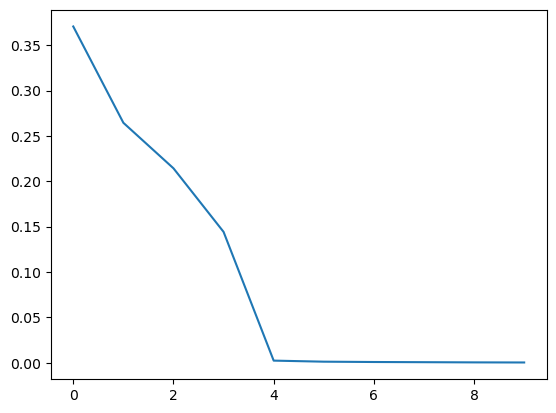

In [91]:
pca = decomposition.PCA()
pca.fit(vecs)
plt.plot(pca.explained_variance_ratio_[:10])
comp = pca.components_[:4]

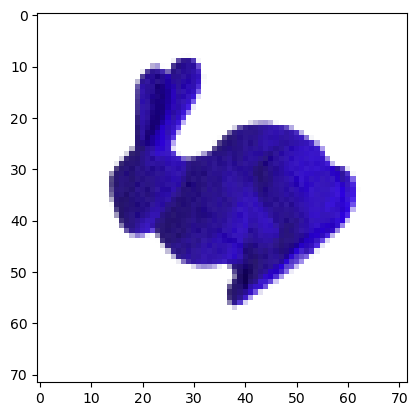

In [92]:
plt.imshow(np.moveaxis(dhandler[0][0][0],0,-1))
img = dhandler[0][0][0][None,...]

In [149]:
@interact
def plot(t1=(-10,10,0.1),t2=(-10,10,0.1),t3=(-10,10,0.1),t4=(-10,10,0.1)):
    t = np.array([t1,t2,t3,t4])
    action_alg = (t@comp).reshape(1,11,11)

    with torch.no_grad():
        x = torch.Tensor(img).to(device)
        z,_,_ = net.encode(x)
        a = torch.Tensor(action_alg).to(device)
        a = torch.matrix_exp(a)
        z2 = torch.einsum("...jk,...k->...j",a,z)[None,...]
        xh = torch.sigmoid(net.decode(z2))[0,0]


    plt.imshow(np.moveaxis(xh.cpu().numpy(),0,-1))

interactive(children=(FloatSlider(value=0.0, description='t1', max=10.0, min=-10.0), FloatSlider(value=0.0, de…

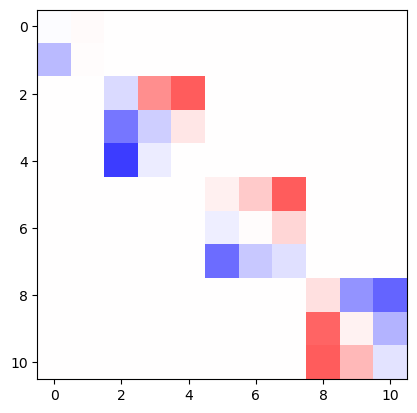

In [122]:
plt.imshow(comp[2].reshape(11,11),cmap='bwr',vmin=-0.5,vmax=0.5)

In [150]:
fig_dir = os.path.join(exp_dir,'figs')

In [153]:
for i in range(4):
    os.makedirs(os.path.join(fig_dir,f'{i}'))
    t = np.zeros([11,4])
    t[:,i] = np.arange(-5,6)

    action_alg = (t@comp).reshape(-1,11,11)

    with torch.no_grad():
        x = torch.Tensor(img).to(device)
        z,_,_ = net.encode(x)
        a = torch.Tensor(action_alg).to(device)
        a = torch.matrix_exp(a)
        z2 = torch.einsum("...jk,...k->...j",a,z)[:,None,...]
        xh = torch.sigmoid(net.decode(z2))
    for j in range(xh.shape[0]):
        fig, ax = plt.subplots(figsize=(4,4))
        ax.imshow(np.moveaxis(xh[j,0].cpu().numpy(),0,-1))
        ax.axis('off')
        plt.savefig(os.path.join(fig_dir,f'{i}/{j}.pdf'))
        plt.close()

/var/lib/condor/execute/dir_855809/ipykernel_860674/3159381298.py:12: UserWarning: An output with one or more elements was resized since it had shape [2, 11, 11], which does not match the required output shape [1, 2, 11, 11]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484810403/work/aten/src/ATen/native/Resize.cpp:17.)
  a = torch.matrix_exp(a)


In [141]:
xh.shape

torch.Size([11, 1, 3, 72, 72])

In [137]:
a.shape

torch.Size([11, 11, 11])

array([[[-0.8 , -0.8 , -0.8 , ..., -0.8 , -0.8 , -0.8 ],
        [-0.64, -0.64, -0.64, ..., -0.64, -0.64, -0.64],
        [-0.48, -0.48, -0.48, ..., -0.48, -0.48, -0.48],
        ...,
        [ 0.48,  0.48,  0.48, ...,  0.48,  0.48,  0.48],
        [ 0.64,  0.64,  0.64, ...,  0.64,  0.64,  0.64],
        [ 0.8 ,  0.8 ,  0.8 , ...,  0.8 ,  0.8 ,  0.8 ]],

       [[-0.8 , -0.8 , -0.8 , ..., -0.8 , -0.8 , -0.8 ],
        [-0.64, -0.64, -0.64, ..., -0.64, -0.64, -0.64],
        [-0.48, -0.48, -0.48, ..., -0.48, -0.48, -0.48],
        ...,
        [ 0.48,  0.48,  0.48, ...,  0.48,  0.48,  0.48],
        [ 0.64,  0.64,  0.64, ...,  0.64,  0.64,  0.64],
        [ 0.8 ,  0.8 ,  0.8 , ...,  0.8 ,  0.8 ,  0.8 ]],

       [[-0.8 , -0.8 , -0.8 , ..., -0.8 , -0.8 , -0.8 ],
        [-0.64, -0.64, -0.64, ..., -0.64, -0.64, -0.64],
        [-0.48, -0.48, -0.48, ..., -0.48, -0.48, -0.48],
        ...,
        [ 0.48,  0.48,  0.48, ...,  0.48,  0.48,  0.48],
        [ 0.64,  0.64,  0.64, ...,  0.64,  0.